# Exercise 2 - Interactive time series

In this exercise we will look at visualizing time series data in an interactive way. As a first step we will look at some easy way to make your matplotlib figures more interactive. However as this has limited functionality we will then look at a package called [Bokeh](https://bokeh.pydata.org/en/latest).

![Figure not available](../images/Bokeh_logo.png)

Bokeh is an interactive visualization library that targets modern web browsers for presentation. Its goal is to provide elegant, concise construction of versatile graphics, and to extend this capability with high-performance interactivity over very large or streaming datasets. Bokeh allows you to quickly and easily create interactive plots, dashboards, and data applications.

[Examples](https://bokeh.pydata.org/en/latest/docs/gallery.html)

<a href="https://bokeh.pydata.org/en/latest/docs/gallery.html"><img src="../images/Bokeh_examples.png" alt="Figure not available"><a>

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure

from bokeh.layouts import column
from bokeh.models import DatetimeTickFormatter, HoverTool, CrosshairTool

# Allowing bokeh to be interactive in the notebook
output_notebook()

Loading BokehJS ...

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
# Allowing matplotlib to be interactive in the notebook
%matplotlib notebook

## 2.1 Using matplotlib for interactive visualization
For this first exercise we will visualize water level data of several stations along the Dutch coast. These data we have obtained from the [waterinfo website](http://waterinfo.rws.nl/#!/kaart/waterhoogte-t-o-v-nap/). The pre-processed data have been stored in a file called Filtered_Kust.csv in the data folder.
</br>

<p>
For the pre-processing steps, please see the script: Pre2 - Interactive time series.ipynb in the answers folder.
</p>

The first step is to load the data from the CSV file using the [read_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html#pandas.read_csv) function and quickly inspect the data using the [pandas](https://pandas.pydata.org/) functions [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html?highlight=head#pandas.DataFrame.head) and [describe()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html#pandas.DataFrame.describe).


In [5]:
DATA_DIR = os.path.abspath(os.path.join(
    os.path.abspath(''), '..', 'data'
))
fname = 'Filtered_Kust.csv'

In [6]:
df = pd.read_csv(os.path.join(DATA_DIR, fname))

In [7]:
# Inspect the data by using the .head() function
df.head()

LOCATION             DATETIME  VALUE
0  Delfzijl  2019-02-01 00:00:00   -8.0
1  Delfzijl  2019-02-01 00:10:00  -19.0
2  Delfzijl  2019-02-01 00:20:00  -30.0
3  Delfzijl  2019-02-01 00:30:00  -41.0
4  Delfzijl  2019-02-01 00:40:00  -53.0

<p>The <code>head()</code> function shows that the <code>DataFrame</code> consists of three columns called: LOCATION, DATETIME and VALUE. The LOCATION column contains a string with the name of the location for which the values are measured. The values are give in cm, and the dates are in the format yyyy-mm-dd HH:MM:SS (in Python: <code>"%Y-%m-%d %H:%M:%S"</code>).</p>

In [8]:
# Inspect the data by using the .describe() function
df.describe()

VALUE
count  43136.000000
mean      12.470952
std       93.237516
min     -273.000000
25%      -53.000000
50%       12.000000
75%       78.000000
max      387.000000

<p>The <code>describe()</code> function shows that there are quite some values in the <code>DataFrame</code>. These are not only for the location Delfzijl, which was visible with the <code>head()</code> function. We can use the <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.unique.html#pandas.Series.unique"><code>unique()</code></a> function, or make a set of the <code>DataFrame</code> column to inspect what other locations are available.</p>

In [9]:
df.LOCATION.unique()

array(['Delfzijl', 'Den Helder', 'Hoek van Holland',
       'IJgeul stroommeetpaal', 'Vlissingen'], dtype=object)

In [10]:
set(df.LOCATION)

{'Delfzijl',
 'Den Helder',
 'Hoek van Holland',
 'IJgeul stroommeetpaal',
 'Vlissingen'}

## 2.2 Default pandas plot
For quick visualization the Pandas package also has a plot function which makes use of the matplotlib package. Let's see what the default plot of pandas looks like. Use the [plot()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html) function to plot the data of the DATETIME (x-axis) and VALUE (y-axis) columns.

<IPython.core.display.Javascript object>


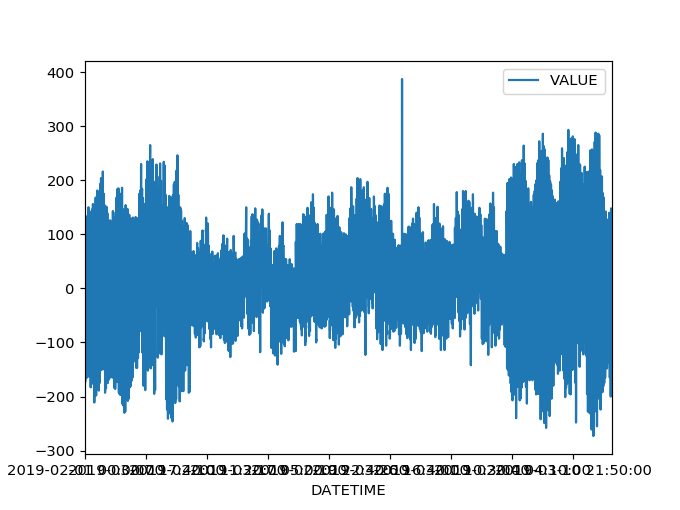

In [11]:
# Plot the data using the plot function and inspect the result
df.plot('DATETIME', 'VALUE')

### What went wrong?
This plot above looks a bit weird. The data of the value column is shown as a single line, however we know that there are multiple locations present in the <code>DataFrame</code>, so we would expect a line for each location. 
Furthermore, the dates at the x-axis are unreadable, zooming in doesn't make it better.

![Figure not available](../images/ex2-fig1_zoom.png "X-axis is unreadable")

We will solve the location problem in the next exercise. First make sure that we can read the dates.

In [12]:
# Find out what the type is of each of the columns of the DataFrame

# Hint: use the dtypes attribute of the DataFrame, or type() function of Python

print(df.dtypes, "\n\n", type(df['DATETIME'].iloc[0]))

LOCATION     object
DATETIME     object
VALUE       float64
dtype: object 

 <class 'str'>


<h2>2.3 Datetime formatting/conversion</h2>

<p>Plotting time series almost always requires some reformatting or processing of the dates so they can be plotted correctly with the package that you are using. Most packages have descriptions on how they will expect the time stamps in the documentation:
</p>
<ul>
    <li><a href="https://matplotlib.org/3.1.0/api/dates_api.html">Matplotlib doc</a></li>
    <li><a href="https://stackoverflow.com/questions/51419925/bokeh-daterangeslider">Bokeh (SO answer)</a></li>
    <li><a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html">Pandas doc</a></li>
</ul>

<p>Of course the datetime package can always be used to pre-process the times, however, in most cases the inbuild functions of the plotting package are very convenient.
</p>

We've put two functions you can use for bokeh below:

    def from_bokeh_timestamp(x, ref_date=datetime.datetime(1970, 1, 1),
                             time_unit="milliseconds"):
        ms = ["milliseconds", "ms"]
        if time_unit in ms:
            time_unit = "seconds"
            x = x / 1000
        new_date = ref_date + datetime.timedelta(**{time_unit: x})
        return new_date


    def to_bokeh_timestamp(x, ref_date=datetime.datetime(1970, 1, 1),
                           time_unit="milliseconds"):
        ms = ["milliseconds", "ms"]
        new_timestamp = (x - ref_date).total_seconds()
        if time_unit in ms:
            new_timestamp = new_timestamp * 1000
        return new_timestamp


### Exercise
<p>Convert the DATETIME column of the <code>DataFrame</code> to a datetime object matplotlib can handle, using the <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html">to_datetime()</a> function of pandas. And check the type of the column again.</p>

In [13]:
# Use the to_datetime function of pandas to convert the 'DATETIME' column in the DataFrame
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

In [14]:
# Find out what the type is of each of the columns of the DataFrame
print(df.dtypes, "\n\n", type(df['DATETIME'].iloc[0]))

LOCATION            object
DATETIME    datetime64[ns]
VALUE              float64
dtype: object 

 <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [15]:
# Plot the data again and inspect the results
df.plot('DATETIME', 'VALUE')

<IPython.core.display.Javascript object>

### Notes about datetime formatting
When plotting the data when the type is an actual timestamp/datetime format, this will automatically order the data on the x-axis.
Please note that in this case the plotting libraries are able to retrieve the datetimeformat from the data itself. In some cases you explicitly need to tell the <code>to_datetime</code> function what the format of the datetime string is before you will be able to convert it to the correct type to be used by the plotting library.

<p>The <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html">to_datetime()</a> function, for example, has
arguments indicating <code>dayfirst</code>, or <code>yearfirst</code>, <code>format</code> to provide your custom datetime formatting.</p>

## 2.4 Filtering the various locations

When zooming in on the data of the previous plot you will notice that the plotted values do not make any sense. The plotted series is a combination of the five previously mentioned locations and as they are for the same period, the plot shows strange jumps and weird connections. An example is shown in the figure below.

![Figure not available](../images/ex2-fig2_zoom.png "Zoom at weird jumps in data")

In the next exercise we will show you how to separate the various locations and show them as separate lines in a matplotlib figure.

for this we will take the following steps:
1. Store the set of locations in a variable called <code>loc_set</code>
2. Define a figure [plt.figure()](https://matplotlib.org/api/figure_api.html?highlight=figure#module-matplotlib.figure)
3. Create a loop over the <code>loc_set</code> variable
4. Within each iteration create a mask based on the location name
5. Use the [plt.plot()](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html?highlight=plot#matplotlib.pyplot.plot) function to plot the relevant subset of the data and add a label for the legend
6. Add a legend with [plt.legend()](https://matplotlib.org/users/legend_guide.html)
7. Do some automatic formatting of the x-axis ([fig.autofmt_xdate()](https://matplotlib.org/api/figure_api.html#matplotlib.figure.Figure.autofmt_xdate)

The result should look something like this:
![Figure not available](../images/ex2-fig3_result.png "Result exercise 2 figure 3")

In [16]:
# Store the locations in a set of locations
loc_set = set(df['LOCATION'])

# Print the set to inspect the values within
print(loc_set)

{'IJgeul stroommeetpaal', 'Vlissingen', 'Den Helder', 'Hoek van Holland', 'Delfzijl'}


## 2.5 Matplotlib plot

In [17]:
# Define the figure
fig = plt.figure()

# Loop through the locations in loc_set
for loc in loc_set:
    
    # Create a mask to filter only the values for this location
    m = df['LOCATION'] == loc
    
    # Plot a line, add label argument to populate legend
    plt.plot(df['DATETIME'][m], df['VALUE'][m], label=loc)

# Add a legend
plt.legend()

# Automatic date formatting
fig.autofmt_xdate()

<IPython.core.display.Javascript object>

## 2.6 Bokeh plot

<p>In this exercise we show the same data but this time shown in a interactive bokeh plot. The code to produce the bokeh plot looks very similar to the initial plot made with matplotlib:</p>
    
1. Use the loc_set variable
2. Define a figure [bokeh.plotting.figure()](https://bokeh.pydata.org/en/latest/docs/reference/plotting.html)
3. Create a loop over the loc_set variable
4. Within each iteration create a mask based on the location name
5. Use the [line()](https://bokeh.pydata.org/en/latest/docs/reference/plotting.html#bokeh.plotting.figure.Figure.line) function to plot the relevant subset of the data
6. Show the figure using [bokeh.plotting.show](https://bokeh.pydata.org/en/latest/docs/reference/io.html#bokeh-io-showing)

<p>
And the resulting plot does so as well. However, there are some differences:
</p>
<ul>
    <li>No distinction in color between lines</li>
    <li>Different date time formatting</li>
    <li>Automatic grid lines, major ticks, minor ticks</li>
    <li>Tool bar on the left with scroll zoom, drag zoom, save as png</li>
</ul>

<p>In the next exercises we will see how to give a unique color to the lines in Bokeh as well. Furthermore, we will learn about the additional tools Bokeh provides to make the plot more informative and interactive.</p>

The result should look something like this:
![Figure not available](../images/ex2-fig4_result.png "Result exercise 2 figure 4")


<button class="btn"><a href="../html/Pizzacourse_ex2_1_basic.html">Interactive example</a></button>

In [18]:
# Define the figure, set x_axis_type to 'datetime'
p = figure(x_axis_type='datetime')

# Loop through the locations in loc_set
for loc in loc_set:
    
    # Create a mask to filter only the values for this location
    m = df['LOCATION'] == loc
    
    # Plot a line in figure p
    p.line(df['DATETIME'][m], df['VALUE'][m], legend=loc)

# Show the figure
show(p)

## Overview matplotlib and bokeh cheat sheet
[Bokeh cheat sheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_Bokeh_Cheat_Sheet.pdf)

[Matplotlib cheat sheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_Matplotlib_Cheat_Sheet.pdf)


## 2.7 Adding unique colors per line
<p>The first step is to add colors to each of the lines. Bokeh does not do this automatically and therefore you will need to set this yourself. You can choose your own colors as well, or use pregenerated lists from the internet.</p>

<p>In this example we chose some colors and provided the hex codes in a list called colors.</p>

<p>Example of subset of colors:</p>
    
    colors = ['#177F75', '#21B6A8', '#7F1769', '#FFCBF4', '#B69521']

Get it from the internet: [Colors](https://www.rapidtables.com/web/color/RGB_Color.html), [More colors](https://hexcolor.co/palette-generator)

Example using bokeh palettes:
    
    from bokeh.palettes import Spectral11
    numlines=len(loc_set)
    mypalette=Spectral11[0:numlines]


<button class="btn"><a href="../html/Pizzacourse_ex2_2_colors.html">Interactive example</a></button>

In [19]:
# Defining the colors
colors = ['#177F75', '#21B6A8', '#7F1769', '#FFCBF4', '#B69521']

p = figure(x_axis_type='datetime')

# Add a zip function to loop through loc_set and colors simultaneously
for (loc, col) in zip(loc_set, colors):
    
    m = df['LOCATION'] == loc
    
    # Add the color attribute to assign a color to the line
    p.line(df['DATETIME'][m], df['VALUE'][m], legend=loc, color=col)
    
show(p)

## 2.8 Adding more tools
<p>
Currently when we zoom we still zoom in both directions (x and y), while it is actually much better to only zoom in the x direction (in time). Bokeh allows us to specify which tools we want to use, here's a list of <a href="https://bokeh.pydata.org/en/latest/docs/user_guide/tools.html">available tools</a>.
</p>
<ul>
    <li><a href="https://bokeh.pydata.org/en/latest/docs/user_guide/tools.html#wheelzoomtool">xwheel_zoom</a>: allowing to zoom in the x direction with the scroll wheel</li>
    <li><a href="https://bokeh.pydata.org/en/latest/docs/user_guide/tools.html#wheelpantool">xpan</a>: allowing to pan in the x direction</li>
    <li><a href="https://bokeh.pydata.org/en/latest/docs/user_guide/tools.html#boxzoomtool">xbox_zoom</a>: allowing to zoom in the x direction by drawing a box</li>
</ul>

<p>Tools can be added in multiple ways in bokeh. All tools have a name, which can be stored as part of a string and read by Bokeh. Alternatively you could make a list with all the Tool objects. Thirdly it is possible to add a bit more attributes to the tools and later add the object to the figure object. We will be using the names as these are descriptive and easy to use, for more information go to <a href="https://bokeh.pydata.org/en/latest/docs/user_guide/tools.html">configuring bokeh tools</a></p>

<p>We can also set which tools we want to be active. In this case we want to automatically set the scroll and pan to be active. This is done by adding the attributes active_scroll and active_drag to the <code>bokeh.plotting.figure()</code> function.</p>


<button class="btn"><a href="../html/Pizzacourse_ex2_3_xzoom.html">Interactive example</a></button>

In [20]:
# Defining all the tools to be used in the figure
Tools_x = 'xwheel_zoom, xpan, xbox_zoom, save, reset'

colors = ['#177F75', '#21B6A8', '#7F1769', '#FFCBF4', '#B69521']

# Add the tools to the figure using the tools attribute, setting active_scroll and active_drag
p = figure(x_axis_type='datetime', tools=Tools_x,
           active_scroll='xwheel_zoom', active_drag='xpan')

for (loc, col) in zip(loc_set, colors):
    m = df['LOCATION'] == loc
    p.line(df['DATETIME'][m], df['VALUE'][m], legend=loc, line_color=col)
    
show(p)

## 2.9 Adding a tooltip (hover) and datetime formatting
<p>
This plot looks much better already. We are able to distinguish the various locations by color and when we zoom in, the y-axis remains the same size, allowing us to easily zoom in to the period we are interested in. Note that we can still toggle on or off any of the tools on the side.
</p>

### Hover tool
<p>When looking at the data it is often difficult to see what the actual value is, by reading the plot. For lines this might be relatively easy, however, for polygons/shapes/rasters this might be more difficult. To make it easier to inspect values in a plot we will introduce the <a href="https://bokeh.pydata.org/en/latest/docs/user_guide/tools.html#hovertool">tooltips</a>.</p>

<p>We will add the hover tool in a slightly different manner to the bokeh plot. Remember the previous tools we added by creating a long string with all the names:</p>

    Tools_x = 'xwheel_zoom, xpan, xbox_zoom, save, reset'

<p>For the hover tool we will use the predefined <code>HoverTool</code> class from <code>bokeh.models</code>:</p>

    hover = HoverTool(tooltips=TOOLTIPS)
    
<p>This object requires some more input, the actual tooltip that should be shown. This can be provided to the class by a list:</p>

    TOOLTIPS = [
        ('value', '@y'),
    ]

<p>In this list the tuples contain the information that needs to be shown on each line. The first element of the tuple is the title, the second part refers to the data. 
Field names that begin with $ are "special fields". These often correspond to values that are intrinsic to the plot, such as the coordinates of the mouse in data or screen space.
Field names that begin with @ are associated with the data that is shown in the graph.</p>

<p>They can also refer to columns in a <code>ColumnDataSource</code>. For instance the field name "@price" will display values from the "price" column whenever a hover is triggered. If the hover is for the 17th glyph, then the hover tooltip will correspondingly display the 17th price value.</p>

To finally add the hover instance to the figure we will use the following line of code:

    p.tools.append(hover)
    
<p>Here we call the <code>p</code> object, which is an instance of the <code>figure</code> class of bokeh. It contains a list-attribute containing all the tools and we just append the newly created hover instance (of the <code>HoverTool</code> class) to the list of tools.</p>

### Date time formatting
<p>
Furthermore, it is possible to sepcify your own <a href="https://bokeh.pydata.org/en/latest/docs/reference/models/formatters.html#">datetime-formatting</a> on the x-axis. For example so that it changes with the period that is being displayed. At the moment this is already using the default, which might be confusing as it will show only hours as soon as you zoom in to to a daily period.</p>

![Figure not available](../images/ex2-fig5_zoom.png "Zoom exercise 2 figure 5")

<p>The <code>DatetimeTickFormatter</code> of bokeh requires a dictionary with as keys the timeunits (e.g. months, days, hours) and each value is a list containing a single string with a datetime format (e.g. ['%y-%m-%d %H:%M'], ['%y-%m-%d']).</p>

<p>An example of such a dictionary is shown below. Modify it/create your own to have some nice date time formatting on the x-axis.</p>

    datetimefmt = dict(
        months=['%y-%m-%d'],
        days=['%y-%m-%d'],
        hours=['%y-%m-%d'],
        hourmin=['%y-%m-%d'],
        minutes=['%y-%m-%d''],
        minsec=['%y-%m-%d'],
        seconds=['%y-%m-%d']
    )


The result should look like this:

![Figure not available](../images/ex2-fig6_zoom.png "Figure 6 exercise 2")


<button class="btn"><a href="../html/Pizzacourse_ex2_4_tooltips.html">Interactive example</a></button>

In [21]:
Tools_x = 'xwheel_zoom, xpan, xbox_zoom, save, reset'

# Define the tooltips
TOOLTIPS = [
    ('value', '@y'),
]

# Create the HoverTool instance
hover = HoverTool(tooltips=TOOLTIPS)

colors = ['#177F75', '#21B6A8', '#7F1769', '#FFCBF4', '#B69521']

p = figure(x_axis_type='datetime', tools=Tools_x,
           active_scroll='xwheel_zoom', active_drag='xpan')

# Add the HoverTool instance
p.tools.append(hover)

for (loc, col) in zip(loc_set, colors):
    m = df['LOCATION'] == loc
    p.line(df['DATETIME'][m], df['VALUE'][m], legend=loc, color=col)

# Define the datetime format dictionary
datetimefmt = dict(
    months=['%y-%m-%d %H:%M'],
    days=['%m-%d %H:%M'],
    hours=['%m-%d %H:%M'],
    hourmin=['%m-%d %H:%M'],
    minutes=['%m-%d %H:%M'],
    minsec=['%m-%d %H:%M'],
    seconds=['%m-%d %H:%M']
)

# Adding the DatetimeTickFormatter
p.xaxis.formatter = DatetimeTickFormatter(**datetimefmt)
show(p)

## 2.10 Adding a vertical line
<p>In case you would be interested to add a value for each of the lines, you could add the <code>mode='vline'</code> attribute to the <code>HoverTool</code>. Instead of selecting the value at the cursor, it will now display the value for the vertical line based on the cursor position.</p>

<p>When only implementing the <code>mode='vline'</code> argument to the <code>HoverTool</code> the graph won't show the vertical line. In case you would also want to show a vertical line at the place the cursor is located, you can use the <code>CrosshairTool</code>. For this tool you would need to specify that it works for the <code>dimensions='height'</code>.
    
You can add the <code>CrosshairTool</code> in the same way we've added the <code>HoverTool</code> in the previous exercise.


<button class="btn"><a href="../html/Pizzacourse_ex2_5_vline_tooltips.html">Interactive example</a></button>

In [22]:
Tools_x = 'xwheel_zoom, xpan, xbox_zoom, save, reset'

TOOLTIPS = [
    ('value', '@y'),
]

# Adding mode='vline' to have a larger selection
hover = HoverTool(tooltips=TOOLTIPS, mode='vline')

# Adding a crosshair to actually show the line
crosshair = CrosshairTool(dimensions='height')

p = figure(x_axis_type='datetime', tools=Tools_x,
           active_scroll='xwheel_zoom', active_drag='xpan')

p.tools.append(hover)

# Add the crosshair tool
p.tools.append(crosshair)

colors = ['#177F75', '#21B6A8', '#7F1769', '#FFCBF4', '#B69521']

for (loc, col) in zip(loc_set, colors):
    m = df['LOCATION'] == loc
    p.line(df['DATETIME'][m], df['VALUE'][m], legend=loc, color=col)

datetimefmt = dict(
    months=['%y-%m-%d %H:%M'],
    days=['%m-%d %H:%M'],
    hours=['%m-%d %H:%M'],
    hourmin=['%m-%d %H:%M'],
    minutes=['%m-%d %H:%M'],
    minsec=['%m-%d %H:%M'],
    seconds=['%m-%d %H:%M']
)

p.xaxis.formatter = DatetimeTickFormatter(**datetimefmt)
show(p)

## 2.11 Subplots
We now have a nice plot with five lines for the various locations, we have the changed the formatting of the x-axis and added tooltips if we move the cursor over the plot. However, unless we zoom in, the plot is still a bit messy, and we cannot always see clearly what the values are. Perhaps it would be nicer to split the plot in two subplots, both for a subset of the locations.

In this excercise you will learn how to implement subplots in Bokeh. This will touch upon the core idea of bokeh, where everything is build up from blocks and those blocks can easily be combined in larger blocks. Creating subplots in Bokeh just means creating another figure and subsequently combining these to figures in a large block (a <code>column</code> in this case). There are much more possibilities for changing lay-outs in the [documentation](https://bokeh.pydata.org/en/latest/docs/reference/layouts.html).

In this exercise we will do the following:
1. Specify the plot properties in a separate <code>dictionary</code>
2. Create a second <code>bokeh.plotting.figure</code>
3. Tell the second figure to follow the <code>x_range</code> of the first figure 
4. Build an if statement to filter out the locations Vlissingen and Hoek van Holland
5. Add the tools, and formatters for both figures
6. Create a <code>column</code> with both figures in it
7. Show this <code>column</code>
8. Store the figure in an interactive HTML-page


<button class="btn"><a href="../html/Pizzacourse_ex2_6_subplots.html">Interactive example</a></button>

In [23]:
Tools_x = 'xwheel_zoom, xpan, xbox_zoom, save, reset'

TOOLTIPS = [
    ('value', '@y'),
]

hover = HoverTool(tooltips=TOOLTIPS, mode='vline')
crosshair = CrosshairTool(dimensions='height')

# Define all the generic plot properties in a single dictionary
plt_prop = dict(x_axis_type='datetime', tools=Tools_x,
           active_scroll='xwheel_zoom', active_drag='xpan', height=400, width=800)

# Create the figure p1 and p2 by using the plt_prop dictionary, couple the x_range of p2 to the p1.x_range 
p1 = figure(**plt_prop)
p2 = figure(**plt_prop, x_range=p1.x_range)

# Add the hover tool to both figures
p1.tools.append(hover)
p2.tools.append(hover)

# Add the crosshair tool to both figures
p1.tools.append(crosshair)
p2.tools.append(crosshair)

colors = ['#177F75', '#21B6A8', '#7F1769', '#FFCBF4', '#B69521']

for (loc, col) in zip(loc_set, colors):
    m = df['LOCATION'] == loc
    
    # Add an if station to filter the stations Vlissingen and Hoek van Holland
    if loc in ['Vlissingen', 'Hoek van Holland']:
        p1.line(df['DATETIME'][m], df['VALUE'][m], legend=loc, color=col)
    else:    
        p2.line(df["DATETIME"][m], df['VALUE'][m], legend=loc, color=col)
    
datetimefmt = dict(
    months=['%y-%m-%d %H:%M'],
    days=['%m-%d %H:%M'],
    hours=['%m-%d %H:%M'],
    hourmin=['%m-%d %H:%M'],
    minutes=['%m-%d %H:%M'],
    minsec=['%m-%d %H:%M'],
    seconds=['%m-%d %H:%M']
)

# Add the DatetimeTickFormatter to both figures
p1.xaxis.formatter = DatetimeTickFormatter(**datetimefmt)
p2.xaxis.formatter = DatetimeTickFormatter(**datetimefmt)

# Put both figures in a column
p = column(p1, p2)

# Create a HTML file to store the graph
output_file('Pizzacourse_ex2_final.html')

show(p)